# Time series clustering exercise

In [433]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy

%matplotlib inline

# Get the data and clean it up

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [23]:
def get_puidata():
    puidata = os.getenv("PUIDATA")
    if puidata is None:
        sys.stderr.write("PUIDATA environment variable must be defined.")
        sys.exit(1)
    else:
        return puidata

In [24]:
puidata = get_puidata()

In [59]:
def download_file(url, directory=puidata, filename=None):
    if not os.path.isdir(directory):
        sys.stderr.write("You must either specify the directory or set puidata.")
        sys.exit(1)
    if filename is None:
        filename = url.split("/")[-1].split("?")[0]
    else:
        filename = filename
    os.system("wget -O " + directory + "/" + filename + " " +
              url)
    full_path = directory + "/" + filename
    if os.path.isfile(full_path):
        return full_path
    else:
        sys.stderr.write("Unable to download file.")
        sys.exit(1)

In [55]:
def get_census_data():
    filenames = []
    for year in range(1994, 2015):
        last_two_digits = str(year)[-2:]
        url = ("https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp"
               + last_two_digits
               + "totals.zip?raw=true")
        filenames.append(download_file(url))
    return filenames

In [83]:
census_data_zip_filenames = get_census_data()
shapefile_zip = download_file("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", 
                              filename="ZIP_CODE_040114.zip")

In [90]:
def extract_file(path_to_zip, filename):
    os.system("unzip -o -d " + puidata + " " + path_to_zip)
    full_path = puidata + "/" + filename
    if os.path.isfile(full_path):
        return full_path
    else:
        sys.stderr.write("Problem unzipping file: " % filename)
        sys.exit(1)

In [91]:
shapefile_shp = shapefile_zip.replace('.zip','.shp').split("/")[-1]
shapefile_shp_path = extract_file(shapefile_zip, shapefile_shp)

/nfshome/aaw329/PUIdata/ZIP_CODE_040114.shp


In [92]:
zip_gdf = gpd.read_file(shapefile_shp_path)

In [99]:
zip_gdf.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [150]:
num_zips = zip_gdf["ZIPCODE"].count()
print(num_zips)

263


In [394]:
#zip_gdf.plot(figsize=(10,10))

In [105]:
census_df_list = []
for zip_path in census_data_zip_filenames:
    file_to_extract = zip_path.replace(".zip", ".txt").split("/")[-1]
    csv_file = extract_file(zip_path, file_to_extract)
    census_df_list.append(pd.read_csv(csv_file))

In [191]:
for i, df in enumerate(census_df_list):
    year = 1994 + i
    # Drop all rows where zip codes aren't found in the shapefile
    try:
        census_df_list[i] = df[df["zip"].isin(zip_gdf["ZIPCODE"].astype(int))]
    except KeyError:  # Some of the column headers are all capitalized and others are lowercase
        census_df_list[i].columns = map(str.lower, df.columns)
        census_df_list[i] = df[df["zip"].isin(zip_gdf["ZIPCODE"].astype(int))]
    census_df_list[i] = df[["zip", "est"]]
    census_df_list[i].rename(index=str, columns={"est": str(year)}, inplace=True)  # Rename "est" to the year
    print(census_df_list[i].shape)
    #print(df.columns)

(240, 2)
(237, 2)
(238, 2)
(238, 2)
(238, 2)
(236, 2)
(239, 2)
(239, 2)
(238, 2)
(238, 2)
(237, 2)
(239, 2)
(241, 2)
(242, 2)
(240, 2)
(240, 2)
(242, 2)
(241, 2)
(239, 2)
(239, 2)
(238, 2)


In [195]:
census_df_list[2].head()

,zip,1996
2998,10001,7075
2999,10002,1919
3000,10003,3417
3001,10004,1133
3002,10005,1216


In [197]:
census_df_list[15].head()

,zip,2009
2929,10001,7305
2930,10002,2775
2931,10003,4099
2932,10004,1379
2933,10005,1274


In [211]:
# Note that we have data for 21 years, even though the instructions say we should have 20
num_census_years = len(census_df_list)  
print(num_census_years)

21


In [206]:
# Merge all of the census DataFrames into one containing all years
for i, df in enumerate(census_df_list):
    if i == 0:
        census_all_df = df
    else:
        census_all_df = census_all_df.merge(df, left_on="zip", right_on="zip", how="outer")

In [210]:
print(census_all_df.shape)
census_all_df.head()

(245, 22)


,zip,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,10001.0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
1,10002.0,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
2,10003.0,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
3,10004.0,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
4,10005.0,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [222]:
census_nd = census_all_df.set_index("zip").values  # Set zip as index so .values is just time series data

In [238]:
census_nd = census_all_df.set_index("zip").dropna().values  # Actually, remove rows with NaNs

In [239]:
# Check std and mean before pre-processing the data
print(census_nd[0].std())
print(census_nd[0].mean())

134.472716804
7252.42857143


In [240]:
for i, row in enumerate(census_nd):
    census_nd[i] = (census_nd[i] - census_nd[i].mean()) / census_nd[i].std()

In [241]:
# After pre-processing, the std should be 1 and mean should be close to 0
print(census_nd[0].std())
print(census_nd[0].mean())

1.0
-9.09325524931e-16


# K-means clustering

In [346]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters, random_state=1234).fit(census_nd)

In [347]:
km.labels_.shape

(230,)

In [348]:
km.get_params()

{'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 5,
 'n_init': 10,
 'n_jobs': 1,
 'precompute_distances': 'auto',
 'random_state': 1234,
 'tol': 0.0001,
 'verbose': 0}

In [349]:
km.cluster_centers_

array([[-1.35390887, -1.27961728, -1.17650285, -1.03098086, -0.92392658,
        -0.89816241, -0.76974696, -0.66861065, -0.28587098, -0.14672204,
         0.01839597,  0.15137498,  0.18017832,  0.37922973,  0.50027526,
         0.62255285,  0.88842091,  1.07153789,  1.32613969,  1.59518026,
         1.8007636 ],
       [ 0.38015399,  0.72016912,  0.82494164,  0.92065676,  0.98970717,
         1.02905228,  0.9941868 ,  0.69420135,  0.01672553,  0.00406198,
         0.24159349,  0.04728609, -0.00612424, -0.32763923, -0.47723421,
        -0.59500262, -0.86045226, -1.05324482, -1.1639679 , -1.20448082,
        -1.17459009],
       [-1.25905957, -1.00869078, -0.662363  , -0.26669392, -0.03335219,
         0.18547393,  0.98372601,  1.10979064,  0.90490215,  0.75753599,
         0.77878894,  0.31915524,  0.13175065, -0.23458944, -0.498482  ,
        -0.59706397, -0.44358345, -0.62080506, -0.08301513,  0.21164267,
         0.3249323 ],
       [-2.04915931, -1.6689629 , -1.35394368, -0.91042642

### Plot each cluster

In [350]:
years = [str(year) for year in range(1994, 2015)]  # Create list of years

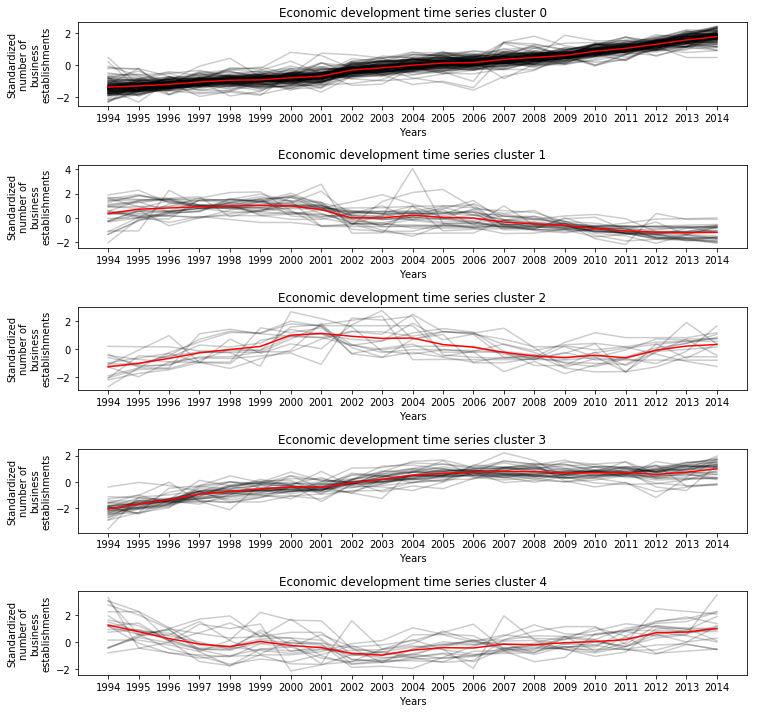

In [351]:
# Plot each category separately
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.7)
for i, category in enumerate(np.unique(km.labels_)):
    ax = fig.add_subplot(num_clusters, 1, i + 1)
    
    # Plot the time series for the category
    ax.plot(years, 
            census_nd[np.where(km.labels_ == category)].T,
            color="black",
            alpha=0.2
           )
    # Plot the center of the cluster
    ax.plot(years, km.cluster_centers_[i], color="red")
    
    # Add labels
    ax.set_title("Economic development time series cluster %s" % str(category))
    ax.set_xlabel("Years")
    ax.set_ylabel("Standardized\nnumber of\nbusiness\nestablishments")
plt.legend()
plt.show()

#### Figure 1: five clusters of time series economic development data (more precisely, the number of business establishments) by ZIP code in New York City over the period from 1994 to 2014, created by a k-means clustering algorithm. Most ZIP codes were placed in the first cluster, with an upward trend.

In [358]:
type(km.labels_)

numpy.ndarray

In [371]:
census_all_df_nona = census_all_df.dropna()
census_all_df_nona.is_copy = False  # Change this to False to suppress a warning regarding the following line
census_all_df_nona["cluster"] = km.labels_
zip_clusters = census_all_df_nona[["zip", "cluster"]]

In [376]:
zip_gdf["ZIPint"] = zip_gdf["ZIPCODE"].astype(int)
zip_cluster_gdf = zip_gdf.merge(zip_clusters, left_on="ZIPint", right_on="zip", how="inner")

(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395504)

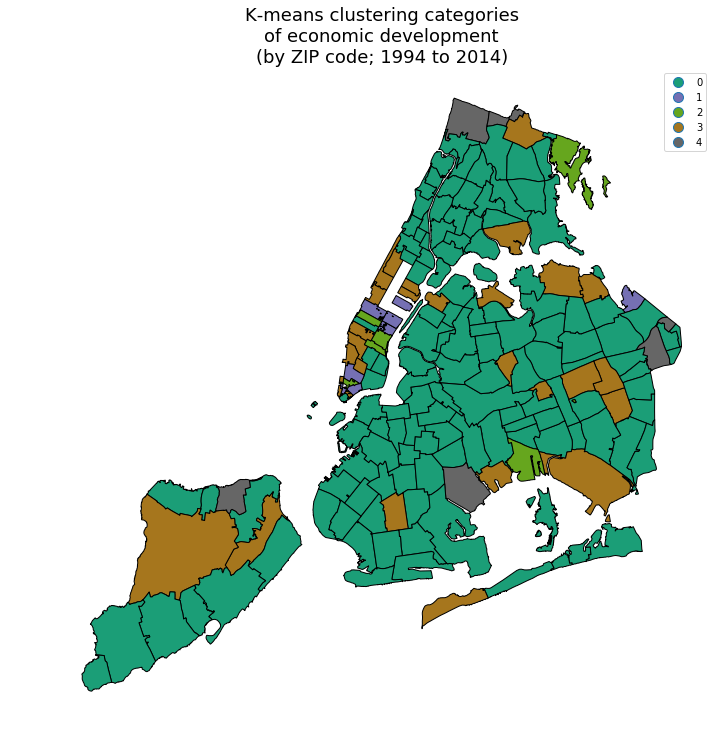

In [399]:
ax = zip_cluster_gdf.plot(figsize=(12,12), 
                          column="cluster", 
                          categorical=True, 
                          legend=True,
                          edgecolor="black",
                          cmap="Dark2"
                         )
ax.set_title("K-means clustering categories\nof economic development\n(by ZIP code; 1994 to 2014)", fontsize=18)
ax.axis("off")

#### Figure 2: a choropleth showing ZIP codes of New York City by cluster, determined by a k-means clustering algorithm. There are 5 clusters, differentiated by color, each representing a measure of economic development: the number of established businesses over a period of 21 years from 1994 to 2014. 

# Agglomerative clustering

In [420]:
agc = AgglomerativeClustering(n_clusters=num_clusters, linkage="average").fit(census_nd)

In [421]:
agc.get_params()

{'affinity': 'euclidean',
 'compute_full_tree': 'auto',
 'connectivity': None,
 'linkage': 'average',
 'memory': Memory(cachedir=None),
 'n_clusters': 5,
 'n_components': None,
 'pooling_func': <function numpy.core.fromnumeric.mean>}

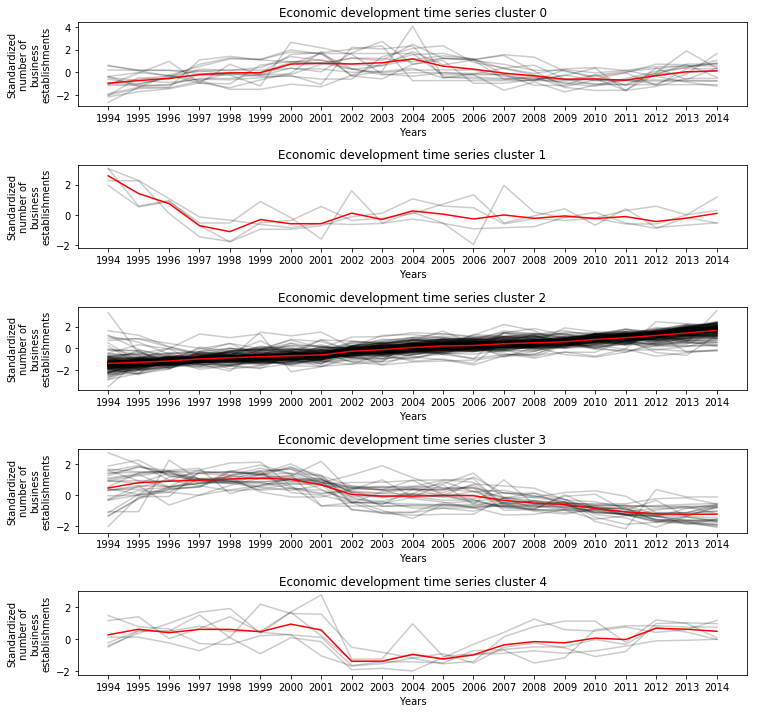

In [422]:
# Plot each category separately
fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.7)
for i, category in enumerate(np.unique(agc.labels_)):
    ax = fig.add_subplot(num_clusters, 1, i + 1)
    
    # Plot the time series for the category
    ax.plot(years, 
            census_nd[np.where(agc.labels_ == category)].T,
            color="black",
            alpha=0.2
           )
    # Plot the center of the cluster
    # by calculating the mean for all series in a cluster
    ax.plot(years, 
            census_nd[np.where(agc.labels_ == category)].T.mean(axis=1),  
            color="red"
           )
    
    # Add labels
    ax.set_title("Economic development time series cluster %s" % str(category))
    ax.set_xlabel("Years")
    ax.set_ylabel("Standardized\nnumber of\nbusiness\nestablishments")
plt.legend()
plt.show()

#### Figure 3: five clusters of time series economic development data (more precisely, the number of business establishments) by ZIP code in New York City over the period from 1994 to 2014, created by an agglomerative clustering algorithm. Most ZIP codes were placed in the third cluster, with an upward trend. This is similar to how the k-means clustering performed.

In [427]:
census_all_df_nona = census_all_df.dropna()
census_all_df_nona.is_copy = False  # Change this to False to suppress a warning regarding the following line
census_all_df_nona["cluster"] = agc.labels_
zip_clusters = census_all_df_nona[["zip", "cluster"]]

In [428]:
zip_gdf["ZIPint"] = zip_gdf["ZIPCODE"].astype(int)
zip_cluster_gdf = zip_gdf.merge(zip_clusters, left_on="ZIPint", right_on="zip", how="inner")

(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395504)

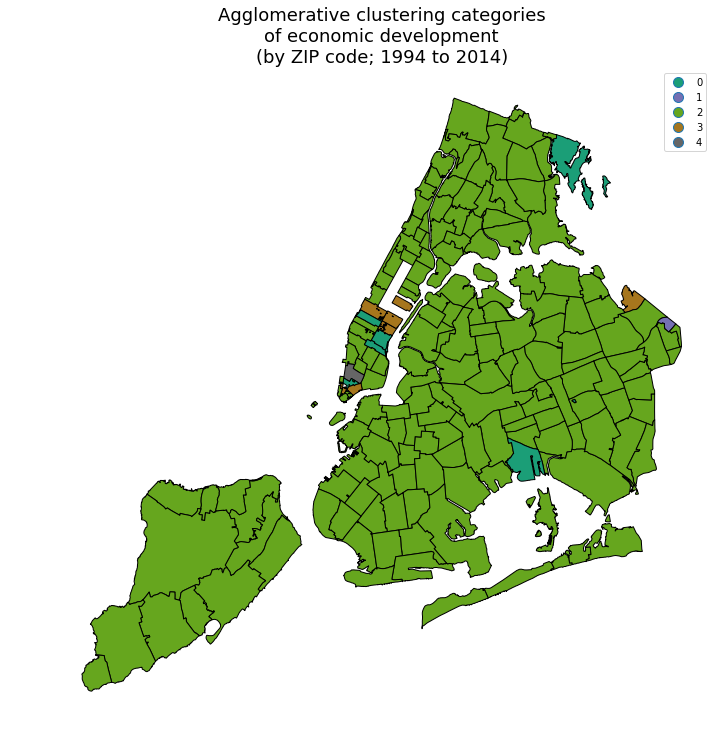

In [430]:
ax = zip_cluster_gdf.plot(figsize=(12,12), 
                          column="cluster", 
                          categorical=True, 
                          legend=True,
                          edgecolor="black",
                          cmap="Dark2"
                         )
ax.set_title("Agglomerative clustering categories\nof economic development\n(by ZIP code; 1994 to 2014)", fontsize=18)
ax.axis("off")

#### Figure 4: a choropleth showing ZIP codes of New York City by cluster, determined by an agglomerative clustering algorithm. There are 5 clusters, differentiated by color, each representing a measure of economic development: the number of established businesses over a period of 21 years from 1994 to 2014. You can see similar patterns found to those that were found with the k-means clustering method above.

# Hierarchical clustering dendrogram

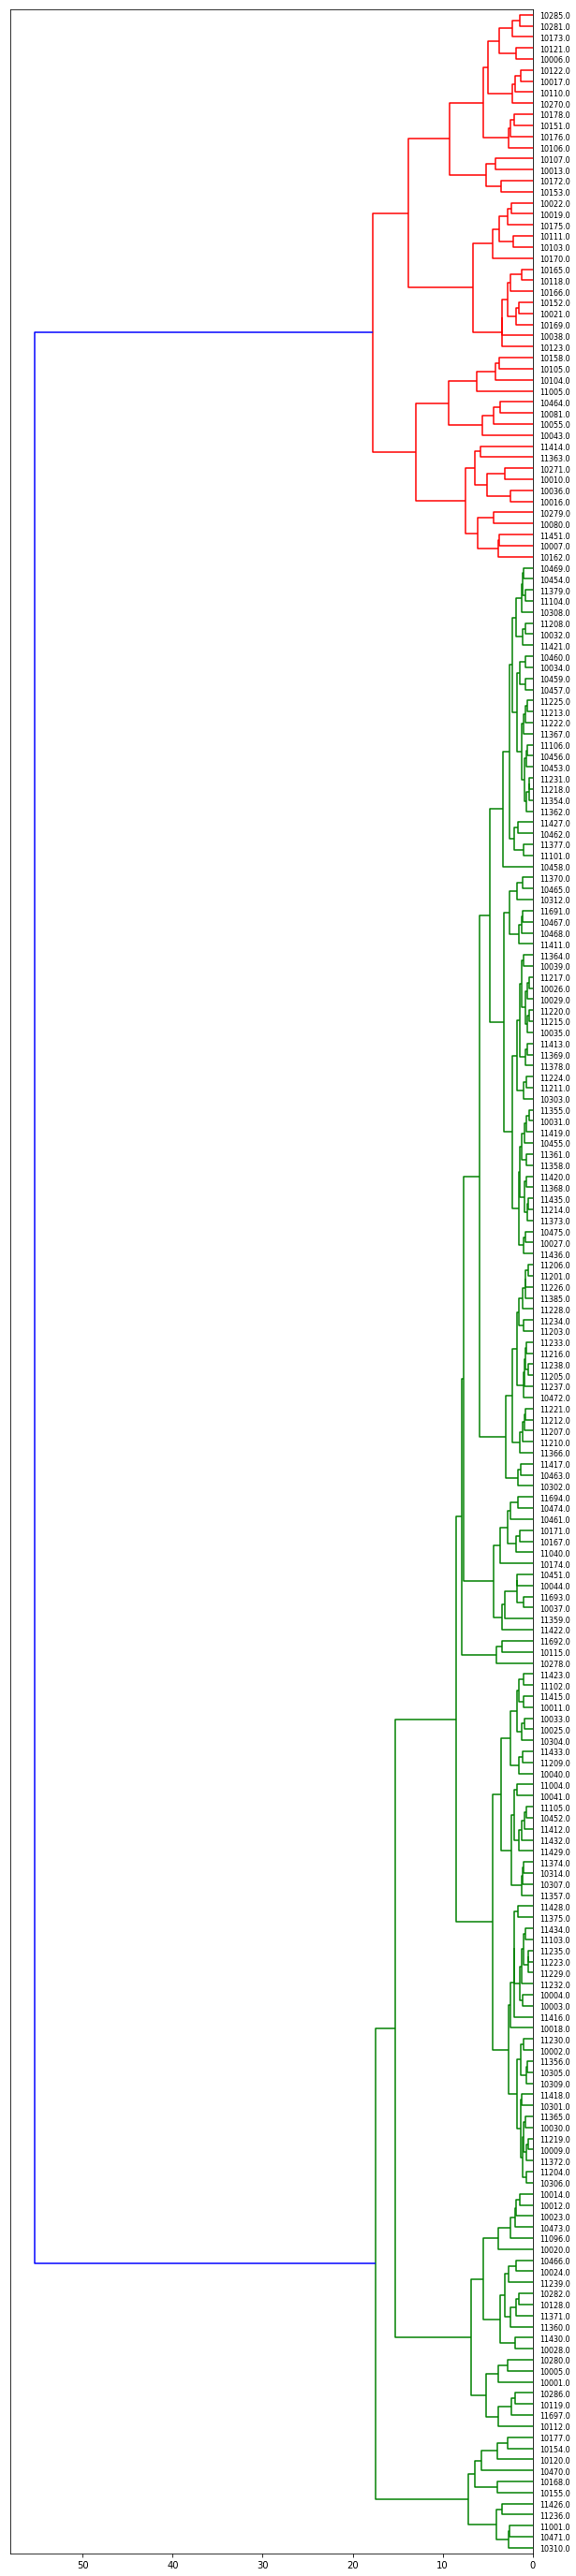

In [445]:
fig = plt.figure(figsize=(10,50))
ddg = hierarchy.dendrogram(hierarchy.linkage(census_nd, method="ward"),
                           labels=census_all_df_nona["zip"].values,
                           orientation="left",
                           leaf_font_size=8
                          )

### Attempted interpretation of the clustering performed
Per the clustered time series graphs and and choropleths showing the ZIP code geographic areas as they have been assigned to clusters, there are some patterns which we can see. Both the k-means clustering and agglomerative clustering both returned one cluster that was larger than the others, and they had an upward trend. This seems to tell us that over our given period of 21 years, a majority of the ZIP codes in New York City have seen an increase in the number of established businesses. However, we also see clusters that have distinctly different behavior. In both sets of clustering plots, we also see a cluster of ZIP codes exhibiting a downward trend, around Midtown Manhattan, Lower Manhattan, and a section of Eastern Queens. There are also similarities between another cluster containing Howard Beach, the Northeast Bronx, and Midtown. It might be interesting to compare the demographics of these clusters to determine correlations between demographics and the economic development data we've used in this exercise. 